<a href="https://www.kaggle.com/code/leekahwin/time-series-4-types-of-evaluation-advance?scriptVersionId=103275456" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

This notebook will show how to perform 4 types of evaluation techniques for time series, i.e., Expanding, Rolling and both Expanding Rolling with Weighted metrics. Oftenly, the latest prediction is more relevant to an interest party. Hence, it make sence that the latest data performance metrics shall have a higher weights than older data. Besides, Expanding evaluation is also called as 'walk forward validation', which is a popular evaluation technique used by many data scientist for time series problem.

# Contents
* [Import Packages and Read Data](#0.1)
* [Make a Forecast Visualisation](#0.2)
* [Rolling Concept](#0.3)
    * [Apply Rolling Concept](#0.4)
* [Expanding Concept](#0.5)
    * [Apply Expanding Concept](#0.6)
* [Make into a Rolling / Expanding function](#0.7)
* [Get Metrics Results](#0.8)
    * [Evaluation through Expanding](#0.9)
    * [Evaluation through Expanding + Weighted](#1.0)
    * [Evaluation through Rolling](#1.1)
    * [Evaluation through Rolling + Weighted](#1.2)

# Import Packages and Read Data <a class="anchor" id="0.1"></a>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tqdm import trange

# install forecast tool and pmdarima
!pip install -q forecast-tool
!pip install -q pmdarima
import pmdarima as pm
from forecast_tool import forecast_plot as fp

matplotlib.style.use('classic')


def duplicate(df, column):
    if len(df[df[column].duplicated()]) ==0:
        print(f'STATUS: There is NO ANY duplicate value in the column of "{column}"')
    else:
        print(f'STATUS: There are {len(df[df[column].duplicated()])} duplicate values in the column of "{column}"')

def shape(df,df_name):
    print(f'STATUS: Dimension of "{df_name}" = {df.shape}')

# read first csv
df = pd.read_csv('/kaggle/input/daily-climate-time-series-data/DailyDelhiClimateTrain.csv')
shape(df,'df')

# change data to correct format
df['date'] = pd.to_datetime(df["date"],errors='coerce')

# # check duplicate
duplicate(df, 'date')
df.head()

STATUS: Dimension of "df" = (1462, 5)
STATUS: There is NO ANY duplicate value in the column of "date"


,date,meantemp,humidity,wind_speed,meanpressure
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000


# Make a Forecast Visualisation <a class="anchor" id="0.2"></a>
Let me show a package that I have recently published, it's called 'forecast_plot', that can help you to find the optimised ARIMA model, get the forecast values, and plot pretty visualisation. For more info, see Package: https://pypi.org/project/forecast-tool/

The date interval for each data points is the same, of 'day' interval
Calibrating best ARIMA
Optimised:  ARIMA(1,1,1)(0,0,0)[0]          
The date interval for each data points is the same, of 'day' interval
Calibrating best ARIMA
Optimised:  ARIMA(1,1,1)(0,0,0)[0]          


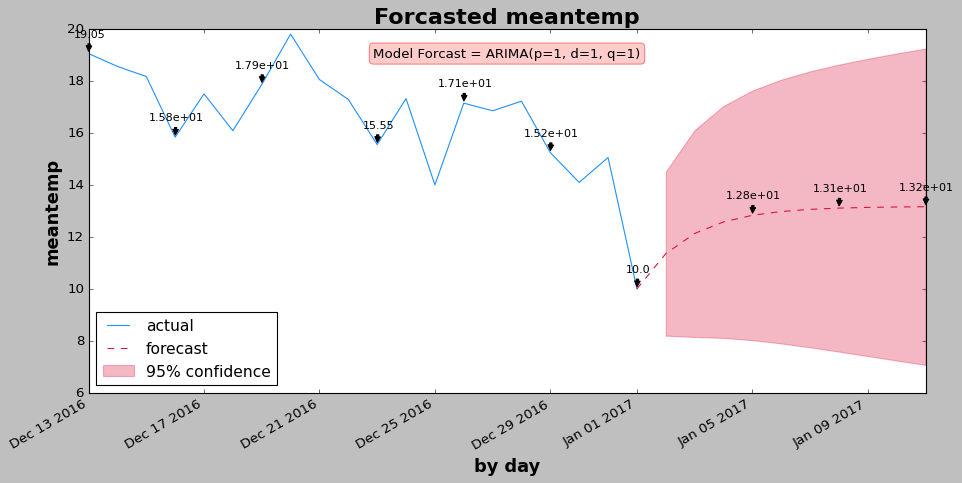

In [2]:
date = 'date' ; target = 'meantemp' ; period = 'd'
df2 = fp.extract_period(df, date, target, period)
best_arima, best_arima_model_name = fp.calibrate_airma(df2, target)
best_arima_order=best_arima.order

fp.overall_vis(df2, date, target, period, suggested_n_forcast=10, zoom_last_n = 30, legend_position=3)

# Rolling Concept <a class="anchor" id="0.3"></a>
Rolling window calculations


<img src="https://user-images.githubusercontent.com/78056833/184537466-bf7f388f-e248-4dea-8193-7bda82848432.png" alt="Rolling" width="600">

In [3]:
arr = [1300, 1700, 1900, 2300, 2400, 2500, 2600, 2700]
window_size = 3
n_periods = 2
len_array = len(arr)+n_periods
prediction = [None] *len_array

row = window_size
last_n_rows = len(arr) +1 - window_size #3

i = 0
while i < last_n_rows:
    array_values = arr[i:i+window_size]
    predictions_result = [np.sum(array_values)/len(array_values)]*n_periods
    
    temp_row = row
    for prediction_answer in predictions_result:
        prediction[temp_row] = prediction_answer
        temp_row+=1
    
    row+=n_periods
    i+=n_periods

prediction

[None,
 None,
 None,
 1633.3333333333333,
 1633.3333333333333,
 2200.0,
 2200.0,
 2500.0,
 2500.0,
 None]

# Apply Rolling Concept <a class="anchor" id="0.4"></a>

In [4]:
model = pm.arima.ARIMA(order = best_arima_order, suppress_warnings =True)
arr = df2.set_index(date)
window_size = 300
n_periods = 20
len_array = len(arr)+n_periods
prediction = [None] *len_array ; AIC = [None] *len_array ; BIC = [None] *len_array

row = window_size
last_n_rows = len(arr) +1 - window_size #3

i = 0
count = 0
print(f"Rolling with {window_size} window size to predict next {n_periods} values")
print(f"Estimated computing {((len(arr)-window_size)/(n_periods))+1:.0f} loops of prediction...")
while i < last_n_rows:
    array_values = arr[i:i+window_size]
    
    predictions_result = model.fit_predict(y = array_values, n_periods = n_periods)
    AIC_result = model.fit(y = array_values, n_periods = n_periods).aicc()
    BIC_result = model.fit(y = array_values, n_periods = n_periods).bic()
    temp_row = row
    for prediction_answer in predictions_result:
        prediction[temp_row] = prediction_answer
        
        # EVALUATION METRICS
        AIC[temp_row] = AIC_result
        BIC[temp_row] = BIC_result
        temp_row+=1
    count+=1
    row+=n_periods
    i+=n_periods
print('Done')
prediction = pd.DataFrame({'Actual':arr[target].values, \
                           'Prediction':prediction[0:len(arr)], \
                           'AICc':AIC[0:len(arr)], \
                           'BIC':BIC[0:len(arr)]}, \
                          index=arr.index)
prediction

Rolling with 300 window size to predict next 20 values
Estimated computing 59 loops of prediction...
Done


,Actual,Prediction,AICc,BIC
date,,,,
2013-01-01,10.000000,NaN,NaN,NaN
2013-01-02,7.400000,NaN,NaN,NaN
2013-01-03,7.166667,NaN,NaN,NaN
2013-01-04,8.666667,NaN,NaN,NaN
2013-01-05,6.000000,NaN,NaN,NaN
...,...,...,...,...
2016-12-28,17.217391,18.046125,1120.749846,1135.416027
2016-12-29,15.238095,18.041238,1120.749846,1135.416027
2016-12-30,14.095238,18.036330,1120.749846,1135.416027


# Expanding Concept <a class="anchor" id="0.5"></a>
The concept of 'out-of-sample' testing is taken to the next level with Expanding technique (aka. walk-forward validation). It is a specific application of the Cross-validation technique. It means using one segment of your data to optimise a system and another segment to validate it.

<img src="https://user-images.githubusercontent.com/78056833/184536290-507e554c-47ad-434d-bf35-d0bdf4aad209.png" alt="Expanding" width="600">

In [5]:
arr = [1300, 1700, 1900, 2300, 2400, 2500, 2600, 2700]
window_size = 3
n_periods = 2
len_array = len(arr)+n_periods
prediction = [None] *len_array

row = window_size
last_n_rows = len(arr) +1 - window_size #3

i = 0
while i < last_n_rows:
    array_values = arr[0:i+window_size]
    predictions_result = [np.sum(array_values)/len(array_values)]*n_periods
    
    temp_row = row
    for prediction_answer in predictions_result:
        prediction[temp_row] = prediction_answer
        temp_row+=1
    
    row+=n_periods
    i+=n_periods

prediction

[None,
 None,
 None,
 1633.3333333333333,
 1633.3333333333333,
 1920.0,
 1920.0,
 2100.0,
 2100.0,
 None]

# Apply Expanding Concept <a class="anchor" id="0.6"></a>

In [6]:
arr = df2.set_index(date)
window_size = 300
n_periods = 20
len_array = len(arr)+n_periods
prediction = [None] *len_array

row = window_size
last_n_rows = len(arr) +1 - window_size #3

i = 0
count = 0
print(f"Expanding with {window_size} window size to predict next {n_periods} values")
print(f"Estimated computing {((len(arr)-window_size)/(n_periods))+1:.0f} loops of prediction...")
while i < last_n_rows:
    array_values = arr[0:i+window_size]
    predictions_result = pm.arima.ARIMA(order = best_arima_order, \
                                        suppress_warnings =True).fit_predict(y = array_values, n_periods = n_periods)

    temp_row = row
    for prediction_answer in predictions_result:
        prediction[temp_row] = prediction_answer
        temp_row+=1
    count+=1
    row+=n_periods
    i+=n_periods
    
print('Done')
prediction = pd.DataFrame({'Actual':arr[target].values,'Prediction':prediction[0:len(arr)]}, index=arr.index)
prediction

Expanding with 300 window size to predict next 20 values
Estimated computing 59 loops of prediction...
Done


,Actual,Prediction
date,,
2013-01-01,10.000000,NaN
2013-01-02,7.400000,NaN
2013-01-03,7.166667,NaN
2013-01-04,8.666667,NaN
2013-01-05,6.000000,NaN
...,...,...
2016-12-28,17.217391,18.039007
2016-12-29,15.238095,18.045002
2016-12-30,14.095238,18.050983


# Make into a Rolling / Expanding function <a class="anchor" id="0.7"></a>

In [7]:
def evaluate(df2, best_arima_order, chosen_seasonal_order,window_size, n_periods, e_method):
    model = pm.arima.ARIMA(order = best_arima_order, \
                           seasonal_order=chosen_seasonal_order,suppress_warnings =True)
    print(model)
    arr = df2.set_index(date)
    len_array = len(arr)+n_periods
    prediction = [None] *len_array ; AIC = [None] *len_array ; BIC = [None] *len_array

    row = window_size
    last_n_rows = len(arr) +1 - window_size #3

    i = 0
    count = 0
    print(f"{e_method} with {window_size} window size to predict next {n_periods} values")
    total_size = f'{((len(arr)-window_size)/(n_periods)):.0f}'
    print(f"Cross-validation by computing {total_size} loops of prediction...")
    
    
    for n in trange(int(total_size), leave =None, colour ='green'):
        if e_method == 'Rolling':
            array_values = arr[i:i+window_size]
        elif e_method == 'Expanding':
            array_values = arr[0:i+window_size]
        else:
            raise Exception('No such evaluation method')

        predictions_result = model.fit_predict(y = array_values, n_periods = n_periods)
        AIC_result = model.fit(y = array_values, n_periods = n_periods).aicc()
        BIC_result = model.fit(y = array_values, n_periods = n_periods).bic()
        temp_row = row
        for prediction_answer in predictions_result:
            prediction[temp_row] = prediction_answer

            # EVALUATION METRICS
            AIC[temp_row] = AIC_result
            BIC[temp_row] = BIC_result
            temp_row+=1
        
        # COUNTER
        count+=1
        row+=n_periods
        i+=n_periods
        
        # break if
        if i >= last_n_rows:
            break
            
    print('Done')
    prediction = pd.DataFrame({'Actual':arr[target].values, \
                               'Prediction':prediction[0:len(arr)], \
                               'AICc':AIC[0:len(arr)], \
                               'BIC':BIC[0:len(arr)]}, \
                              index=arr.index)
    return prediction


# Get Metrics Function <a class="anchor" id="0.8"></a>

In [8]:
def get_metric(prediction, model, e_method, weights_value=None):
    
    result = prediction.dropna()
    # aicc and bic
    aicc_average = np.average(result.AICc.values, weights=weights_value)
    bic_average = np.average(result.BIC.values, weights=weights_value)

    y_true = result.Actual
    y_pred = result.Prediction

    mse = mean_squared_error(y_true, y_pred, sample_weight=weights_value)
    rmse = mean_squared_error(y_true, y_pred, sample_weight=weights_value, squared=False)
    mae = mean_absolute_error(y_true, y_pred, sample_weight=weights_value)
    r2 = r2_score(y_true, y_pred, sample_weight=weights_value)

    d = {'Evaluation_Method':e_method,f'AICc_Average':aicc_average, f'BIC_Average':bic_average,\
         f'MSE':mse,f'RMSE':rmse ,f'MAE':mae, f'R2':r2
        }
    result_df = pd.DataFrame(d, index=[model])
    return result_df

In [9]:
d = {
    best_arima_model_name : best_arima_order,
    'MA(3)': (0,0,3),
    'AR(3)':(3,0,0)
}
for model_name, order_choice in d.items():
    print(order_choice)

(1, 1, 1)
(0, 0, 3)
(3, 0, 0)


# Evaluation through Expanding <a class="anchor" id="0.9"></a>

In [10]:
e_method ='Expanding'
temp=[]
for model_name, order_choice in d.items():
    prediction = evaluate(df2, order_choice, best_arima.seasonal_order,\
                          window_size= 300, n_periods=20, e_method =e_method)
    result = get_metric(prediction, model_name, e_method)
    temp.append(result)
pd.concat(temp)

 ARIMA(1,1,1)(0,0,0)[0] intercept
Expanding with 300 window size to predict next 20 values
Cross-validation by computing 58 loops of prediction...


100%|██████████| 58/58 [00:46<00:00,  1.24it/s]


Done
 ARIMA(0,0,3)(0,0,0)[0] intercept
Expanding with 300 window size to predict next 20 values
Cross-validation by computing 58 loops of prediction...


100%|██████████| 58/58 [03:03<00:00,  3.16s/it]


Done
 ARIMA(3,0,0)(0,0,0)[0] intercept
Expanding with 300 window size to predict next 20 values
Cross-validation by computing 58 loops of prediction...


100%|██████████| 58/58 [01:36<00:00,  1.66s/it]

Done


,Evaluation_Method,AICc_Average,BIC_Average,MSE,RMSE,MAE,R2
"ARIMA(p=1, d=1, q=1)",Expanding,3323.239956,3341.905302,9.302898,3.050065,2.390025,0.829242
MA(3),Expanding,4200.882229,4224.206715,51.079068,7.146962,6.185451,0.062426
AR(3),Expanding,3356.662909,3379.987395,9.404520,3.066679,2.430587,0.827377


# Evaluation through Expanding + Weighted <a class="anchor" id="1.0"></a>

In [11]:
e_method ='Expanding'
for model_name, order_choice in d.items():
    prediction = evaluate(df2, order_choice, best_arima.seasonal_order,\
                          window_size= 300, n_periods=20, e_method =e_method)
    result = get_metric(prediction, model_name, 'Expanding + Weighted', \
                     weights_value=np.arange(0, len(prediction.dropna()), 1))
    temp.append(result)
pd.concat(temp)

 ARIMA(1,1,1)(0,0,0)[0] intercept
Expanding with 300 window size to predict next 20 values
Cross-validation by computing 58 loops of prediction...


100%|██████████| 58/58 [00:47<00:00,  1.22it/s]


Done
 ARIMA(0,0,3)(0,0,0)[0] intercept
Expanding with 300 window size to predict next 20 values
Cross-validation by computing 58 loops of prediction...


100%|██████████| 58/58 [03:06<00:00,  3.21s/it]


Done
 ARIMA(3,0,0)(0,0,0)[0] intercept
Expanding with 300 window size to predict next 20 values
Cross-validation by computing 58 loops of prediction...


100%|██████████| 58/58 [01:29<00:00,  1.54s/it]

Done


,Evaluation_Method,AICc_Average,BIC_Average,MSE,RMSE,MAE,R2
"ARIMA(p=1, d=1, q=1)",Expanding,3323.239956,3341.905302,9.302898,3.050065,2.390025,0.829242
MA(3),Expanding,4200.882229,4224.206715,51.079068,7.146962,6.185451,0.062426
AR(3),Expanding,3356.662909,3379.987395,9.404520,3.066679,2.430587,0.827377
"ARIMA(p=1, d=1, q=1)",Expanding + Weighted,4055.568406,4075.238363,8.972738,2.995453,2.358464,0.817384
MA(3),Expanding + Weighted,5122.431358,5147.013522,47.651951,6.903039,5.960664,0.030173
AR(3),Expanding + Weighted,4093.606182,4118.188346,9.550693,3.090419,2.465873,0.805621


# Evaluation through Rolling <a class="anchor" id="1.1"></a>

In [12]:
e_method ='Rolling'
for model_name, order_choice in d.items():
    prediction = evaluate(df2, order_choice, best_arima.seasonal_order,\
                          window_size= 300, n_periods=20, e_method =e_method)
    result = get_metric(prediction, model_name, e_method)
    temp.append(result)
pd.concat(temp)

 ARIMA(1,1,1)(0,0,0)[0] intercept
Rolling with 300 window size to predict next 20 values
Cross-validation by computing 58 loops of prediction...


100%|██████████| 58/58 [00:25<00:00,  2.26it/s]


Done
 ARIMA(0,0,3)(0,0,0)[0] intercept
Rolling with 300 window size to predict next 20 values
Cross-validation by computing 58 loops of prediction...


100%|██████████| 58/58 [01:21<00:00,  1.40s/it]


Done
 ARIMA(3,0,0)(0,0,0)[0] intercept
Rolling with 300 window size to predict next 20 values
Cross-validation by computing 58 loops of prediction...


100%|██████████| 58/58 [00:56<00:00,  1.03it/s]

Done


,Evaluation_Method,AICc_Average,BIC_Average,MSE,RMSE,MAE,R2
"ARIMA(p=1, d=1, q=1)",Expanding,3323.239956,3341.905302,9.302898,3.050065,2.390025,0.829242
MA(3),Expanding,4200.882229,4224.206715,51.079068,7.146962,6.185451,0.062426
AR(3),Expanding,3356.662909,3379.987395,9.404520,3.066679,2.430587,0.827377
"ARIMA(p=1, d=1, q=1)",Expanding + Weighted,4055.568406,4075.238363,8.972738,2.995453,2.358464,0.817384
MA(3),Expanding + Weighted,5122.431358,5147.013522,47.651951,6.903039,5.960664,0.030173
AR(3),Expanding + Weighted,4093.606182,4118.188346,9.550693,3.090419,2.465873,0.805621
"ARIMA(p=1, d=1, q=1)",Rolling,1126.647114,1141.313295,11.181739,3.343911,2.605981,0.794755
MA(3),Rolling,1418.095876,1436.410707,66.452995,8.151871,7.049557,-0.219768
AR(3),Rolling,1141.937897,1160.252728,9.493367,3.081131,2.439137,0.825746


# Evaluation through Rolling + Weighted <a class="anchor" id="1.2"></a>

In [13]:
e_method ='Rolling'
for model_name, order_choice in d.items():
    prediction = evaluate(df2, order_choice, best_arima.seasonal_order,\
                          window_size= 300, n_periods=20, e_method =e_method)
    result = get_metric(prediction, model_name, 'Rolling + Weighted', \
                     weights_value=np.arange(0, len(prediction.dropna()), 1))
    temp.append(result)
df_result = pd.concat(temp)
df_result

 ARIMA(1,1,1)(0,0,0)[0] intercept
Rolling with 300 window size to predict next 20 values
Cross-validation by computing 58 loops of prediction...


100%|██████████| 58/58 [00:25<00:00,  2.30it/s]


Done
 ARIMA(0,0,3)(0,0,0)[0] intercept
Rolling with 300 window size to predict next 20 values
Cross-validation by computing 58 loops of prediction...


100%|██████████| 58/58 [01:21<00:00,  1.40s/it]


Done
 ARIMA(3,0,0)(0,0,0)[0] intercept
Rolling with 300 window size to predict next 20 values
Cross-validation by computing 58 loops of prediction...


100%|██████████| 58/58 [00:36<00:00,  1.59it/s]

Done


,Evaluation_Method,AICc_Average,BIC_Average,MSE,RMSE,MAE,R2
"ARIMA(p=1, d=1, q=1)",Expanding,3323.239956,3341.905302,9.302898,3.050065,2.390025,0.829242
MA(3),Expanding,4200.882229,4224.206715,51.079068,7.146962,6.185451,0.062426
AR(3),Expanding,3356.662909,3379.987395,9.404520,3.066679,2.430587,0.827377
"ARIMA(p=1, d=1, q=1)",Expanding + Weighted,4055.568406,4075.238363,8.972738,2.995453,2.358464,0.817384
MA(3),Expanding + Weighted,5122.431358,5147.013522,47.651951,6.903039,5.960664,0.030173
AR(3),Expanding + Weighted,4093.606182,4118.188346,9.550693,3.090419,2.465873,0.805621
"ARIMA(p=1, d=1, q=1)",Rolling,1126.647114,1141.313295,11.181739,3.343911,2.605981,0.794755
MA(3),Rolling,1418.095876,1436.410707,66.452995,8.151871,7.049557,-0.219768
AR(3),Rolling,1141.937897,1160.252728,9.493367,3.081131,2.439137,0.825746
"ARIMA(p=1, d=1, q=1)",Rolling + Weighted,1128.904347,1143.570528,11.005646,3.317476,2.600623,0.776010


We can notice that the calibrated model, ARIMA(p=1, d=1, q=1), has the best performance in almost all of the metrics in each evaluation method. Hence, the model is suggested to be selected for future work. 

If you found this notebook useful, feel free to upvote this, Thank you.

-Morris Lee (14/8/2022)